## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import pyplot

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation, partitions, k_folds_indexs
from functions import unscaler, k_folds_indexs, model_fitting_kfold, weighting_models, jsontotable, plot_results, reconstructing_data, my_calibration_plot

In [5]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81', 'var_110', 'var_152'] #'var_175', 'var_183', 'var_199'

<b> random split

In [8]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [9]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [10]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 10000,[True,True], means_train, cov_train )
train_dataset_scaled, scalerx = scaler(train_dataset_distance)

<b> validation_dataset is ussed as the test set

<b> sectioning:

In [11]:
train_section_1, train_section_2, train_section_3 = partitions(train_dataset_scaled)

### Cross validation using K-fold and parameter tunning

### Section 1

In [12]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
Name: mahalanobis, dtype: int64

In [14]:
dict_1 = {'n':5600, 'range': [15,40], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':5000, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':5000, 'range': [15,40], 'label': 4, 'category': 2} # augmetation on the previous random ones

unscld_train_section_1 =unscaler(train_section_1, scalerx)
train_section_1_aug = augmentation_strategy(data = unscld_train_section_1, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_1
train_section_1_aug =  scaler(train_section_1_aug,scalerx)

In [15]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
2     5600
3     5000
4     5000
Name: mahalanobis, dtype: int64

### Model Exploration

### Common data to train and validation

In [16]:
seed = 158
validation_dataset_section1 = train_section_1_aug[train_section_1_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section1 = validation_dataset_section1.copy()
train_dataset_section1 = train_section_1_aug[~train_section_1_aug.index.isin(validation_dataset_section1.index)]

In [17]:
train_dataset_section1_aug = augmentation_selection_rates(train_dataset_section1, rate = 1.0, sample = 0.7)

In [21]:
len(train_dataset_section1_aug)  #30953

19851

In [18]:
validation_dataset_section1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    3600
1     652
Name: mahalanobis, dtype: int64

In [19]:
validation_dataset_section1_balanced =  balance_validation(validation_dataset_section1, 500)

In [20]:
validation_dataset_section1_balanced.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    1152
1     652
Name: mahalanobis, dtype: int64

In [22]:
X_train = train_dataset_section1_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section1_aug['target']

X_val = validation_dataset_section1_balanced[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section1_balanced['target']

#### Support Vector Machine

In [23]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.35, probability = True)
my_svm.fit(X_train, Y_train)

SVC(gamma=0.35, probability=True)

In [24]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [25]:
svm_metrics

{'Train': {'precision': 0.8939119405689436,
  'Accuracy': 0.8157775426930634,
  'AUC': 0.9008323912146291},
 'Validation': {'precision': 0.5501930501930502,
  'Accuracy': 0.6674057649667405,
  'AUC': 0.6795630165729379}}

In [26]:
conf_mat

Pred,0,1
True,,
0,919,233
1,367,285


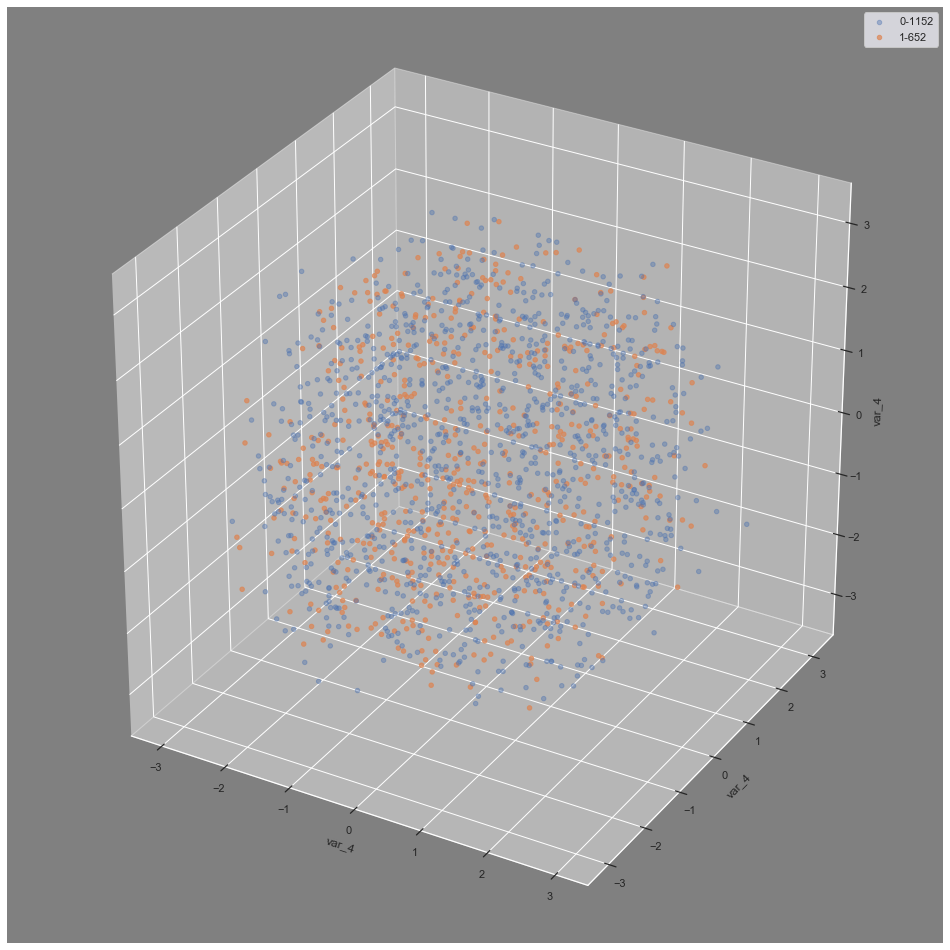

In [27]:
threeD_plot(validation_dataset_section1_balanced,['var_4', 'var_12', 'var_46'], fraq = 1.00)

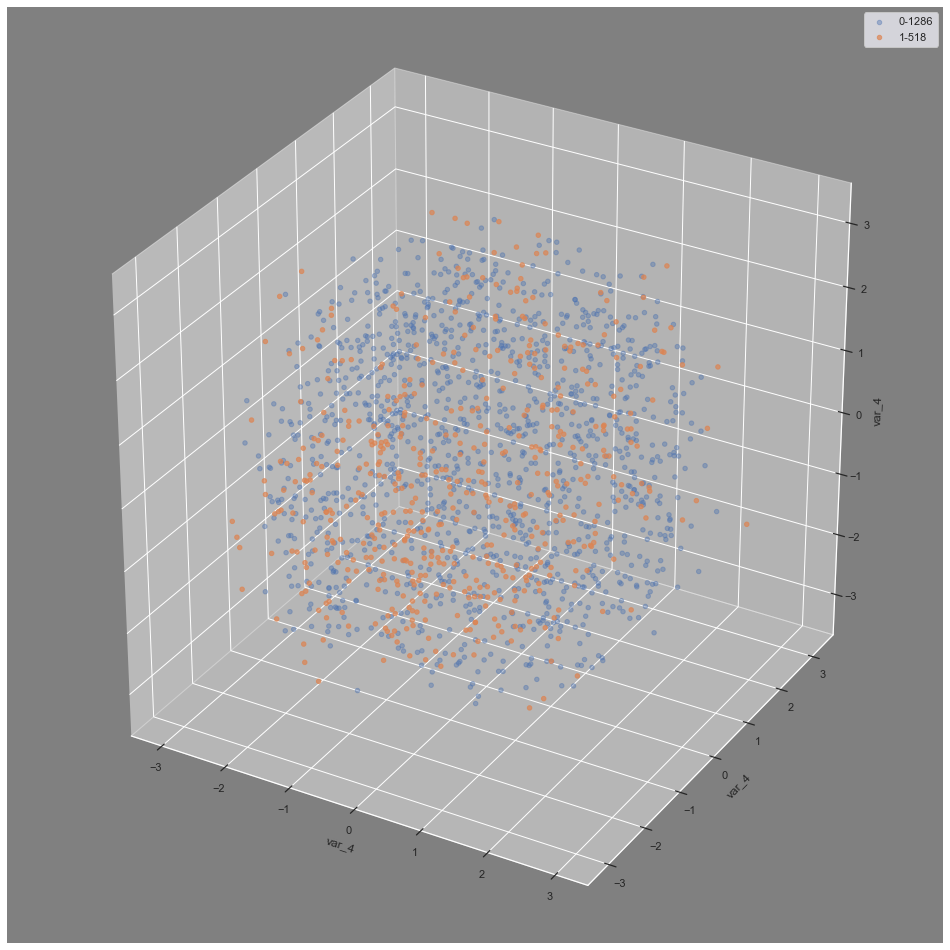

In [28]:
validation_set_pred = validation_dataset_section1_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

<b> Calibration

In [29]:
calibrated_svm = CalibratedClassifierCV(my_svm, method='isotonic', cv=5)
calibrated_svm.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=SVC(gamma=0.35, probability=True), cv=5,
                       method='isotonic')

In [30]:
svm_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_svm, X_train, Y_train, X_val, Y_val)

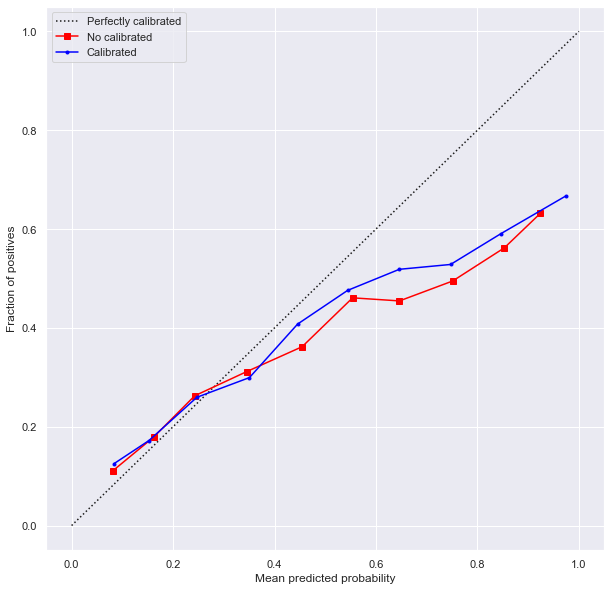

In [31]:
my_calibration_plot(model = my_svm, calibrated_model = calibrated_svm, X_data = X_val, Y_data = Y_val)

### KNN

In [32]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

In [33]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [34]:
knn_metrics

{'Train': {'precision': 0.9279871827304157,
  'Accuracy': 0.8890735983073901,
  'AUC': 0.9632381150151873},
 'Validation': {'precision': 0.5752212389380531,
  'Accuracy': 0.6856984478935698,
  'AUC': 0.7165033071319018}}

In [35]:
conf_mat

Pred,0,1
True,,
0,912,240
1,327,325


In [36]:
validation_dataset_section1.shape

(4252, 7)

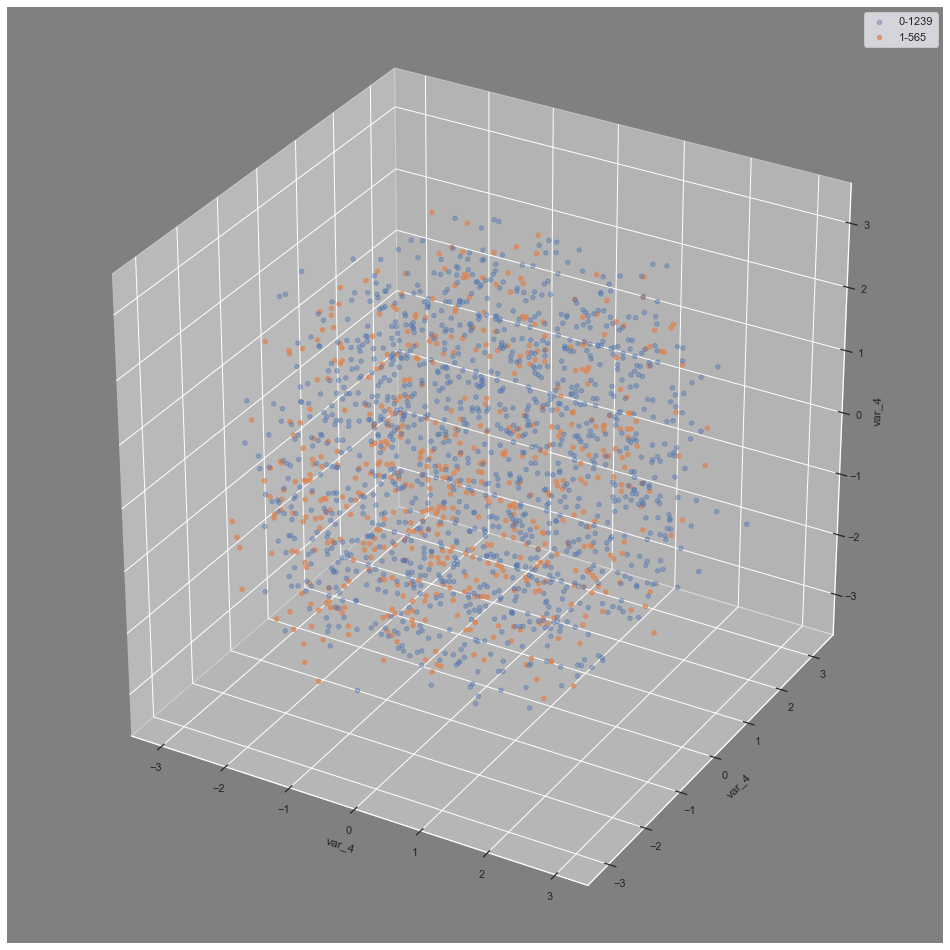

In [37]:
validation_set_pred = validation_dataset_section1_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

<b> Calibration

In [38]:
calibrated_knn = CalibratedClassifierCV(knneig, method='isotonic', cv=5)
calibrated_knn.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=4), cv=5,
                       method='isotonic')

In [39]:
knn_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_knn, X_train, Y_train, X_val, Y_val)

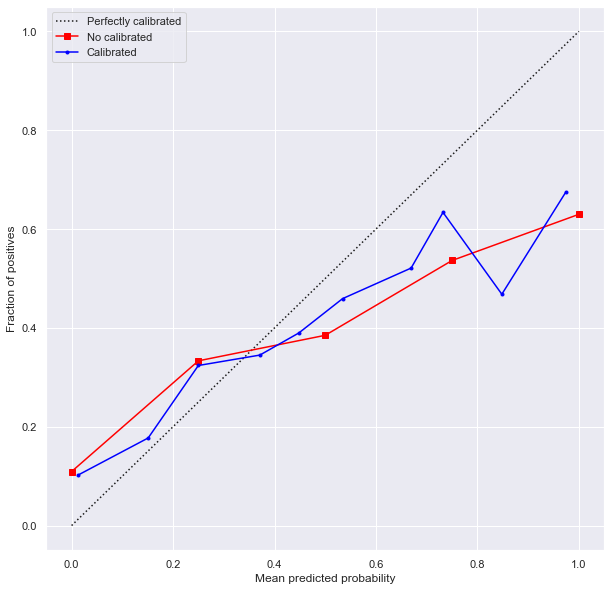

In [40]:
my_calibration_plot(model = knneig, calibrated_model = calibrated_knn, X_data = X_val, Y_data = Y_val)

### Random Forest

In [41]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=20,
                       n_estimators=550)

In [42]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [43]:
rf_metrics

{'Train': {'precision': 0.9672957048928358,
  'Accuracy': 0.9290715832955518,
  'AUC': 0.9838690355205651},
 'Validation': {'precision': 0.7113821138211383,
  'Accuracy': 0.753880266075388,
  'AUC': 0.7860642467620995}}

In [44]:
conf_mat

Pred,0,1
True,,
0,1010,142
1,302,350


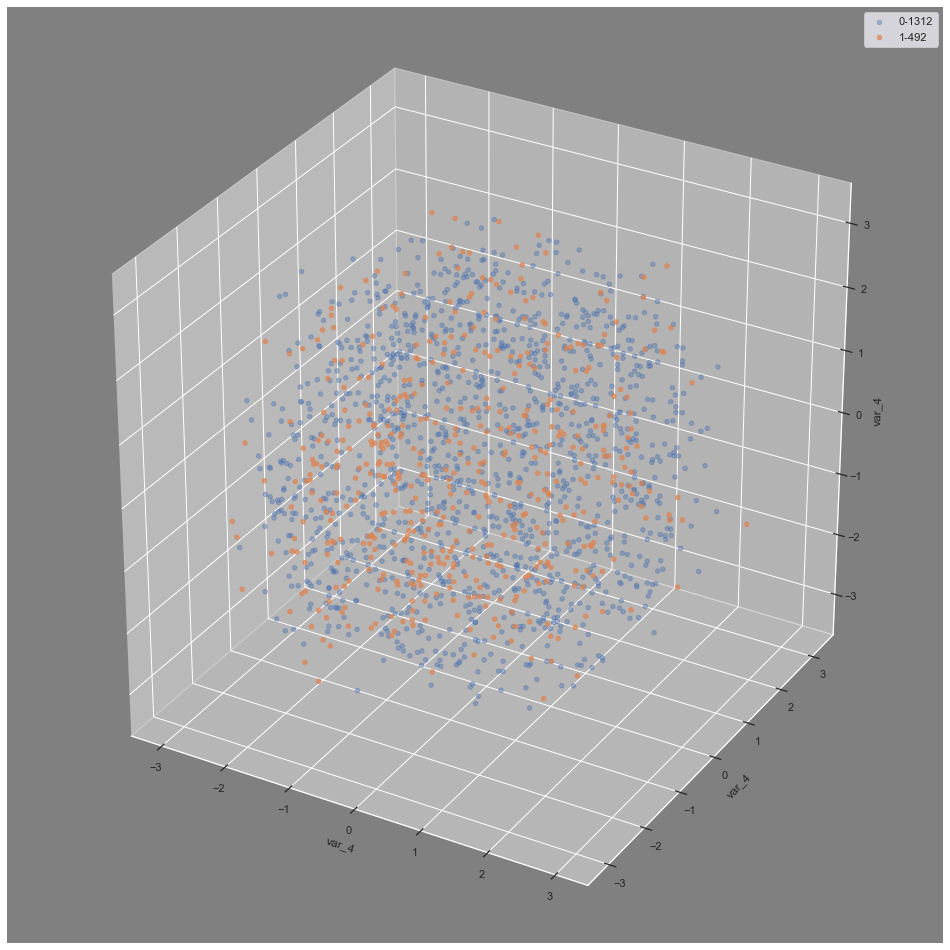

In [45]:
validation_set_pred = validation_dataset_section1_balanced.copy()
validation_set_pred['target'] = predictions_validation

threeD_plot(validation_set_pred,['var_4', 'var_12', 'var_46'], fraq = 1.00)

<b> Calibration

In [46]:
calibrated_rf = CalibratedClassifierCV(rfc, method='isotonic', cv=5)
calibrated_rf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=20,
                                                             min_samples_leaf=6,
                                                             min_samples_split=20,
                                                             n_estimators=550),
                       cv=5, method='isotonic')

In [47]:
rf_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_rf, X_train, Y_train, X_val, Y_val)

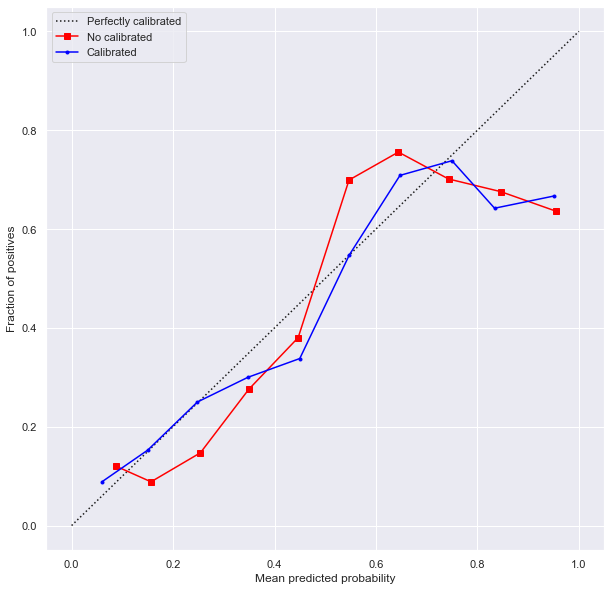

In [48]:
my_calibration_plot(model = rfc, calibrated_model = calibrated_rf, X_data = X_val, Y_data = Y_val)

<b> Summary

In [49]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.550193,0.667406,0.679563
KNN,0.575221,0.685698,0.716503
RF,0.711382,0.753880,0.786064


In [50]:
typex = 'Validation'
pd.DataFrame([svm_metrics_calib[typex],knn_metrics_calib[typex],rf_metrics_calib[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.556237,0.669069,0.681368
KNN,0.529412,0.661308,0.708494
RF,0.663808,0.744457,0.771784


## Section 2

In [12]:
train_section_2.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    57934
1     7076
Name: mahalanobis, dtype: int64

In [13]:
dict_1 = {'n':4000, 'range': [9,15], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':6000, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':5000, 'range': [9,15], 'label': 4, 'category': 2} # augmetation on the previous random ones

unscld_train_section_2 =unscaler(train_section_2, scalerx)
train_section_2_aug = augmentation_strategy(data = unscld_train_section_2, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_2
train_section_2_aug =  scaler(train_section_2_aug,scalerx)

In [14]:
train_section_2_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    57934
1     7076
2     4000
3     6000
4     5000
Name: mahalanobis, dtype: int64

### Common data to train and validation

In [15]:
seed = 158
validation_dataset_section2 = train_section_2_aug[train_section_2_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section2 = validation_dataset_section2.copy()
train_dataset_section2 = train_section_2_aug[~train_section_2_aug.index.isin(validation_dataset_section2.index)]

In [16]:
train_dataset_section2_aug = augmentation_selection_rates(train_dataset_section2, rate = 1.0, sample = 0.9, reduction_falses = 25000)

In [17]:
train_dataset_section2_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14105
1    18277
Name: mahalanobis, dtype: int64

In [18]:
experimental_numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81','var_4', 'var_12', 'var_46']

In [19]:
X_train = train_dataset_section2_aug[experimental_numerical_features + ['mahalanobis']]
Y_train = train_dataset_section2_aug['target']

X_val = validation_dataset_section2[experimental_numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section2['target']

#### Support Vector Machine

In [22]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.35, probability = True)
my_svm.fit(X_train, Y_train)

SVC(gamma=0.35, probability=True)

In [24]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [25]:
svm_metrics

{'Train': {'precision': 0.9989238311610666,
  'Accuracy': 0.8671124727508396,
  'AUC': 0.8594190660053824},
 'Validation': {'precision': 0.16666666666666666,
  'Accuracy': 0.892286221771124,
  'AUC': 0.5521531162839194}}

In [26]:
conf_mat

Pred,0,1
True,,
0,14064,10
1,1688,2


<b> Calibration

In [27]:
calibrated_svm = CalibratedClassifierCV(my_svm, method='isotonic', cv=5)
calibrated_svm.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=SVC(gamma=0.35, probability=True), cv=5,
                       method='isotonic')

In [28]:
svm_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_svm, X_train, Y_train, X_val, Y_val)

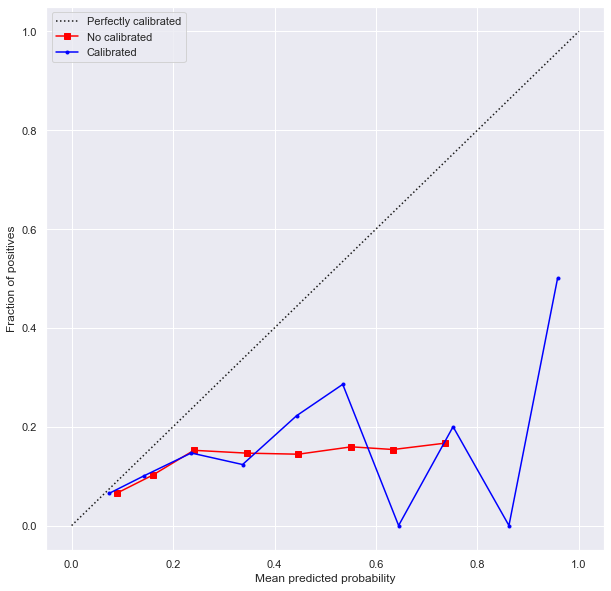

In [29]:
my_calibration_plot(model = my_svm, calibrated_model = calibrated_svm, X_data = X_val, Y_data = Y_val)

### KNN

In [20]:
knneig = KNeighborsClassifier(n_neighbors = 2)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=2)

In [21]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [22]:
knn_metrics

{'Train': {'precision': 1.0,
  'Accuracy': 0.931443394478414,
  'AUC': 0.9799956620921451},
 'Validation': {'precision': 0.19161676646706588,
  'Accuracy': 0.7368939207482156,
  'AUC': 0.660601257080979}}

In [23]:
conf_mat

Pred,0,1
True,,
0,11208,3240
1,1036,768


<b> Calibration

In [24]:
calibrated_knn = CalibratedClassifierCV(knneig, method='isotonic', cv=5)
calibrated_knn.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=2), cv=5,
                       method='isotonic')

In [25]:
knn_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_knn, X_train, Y_train, X_val, Y_val)

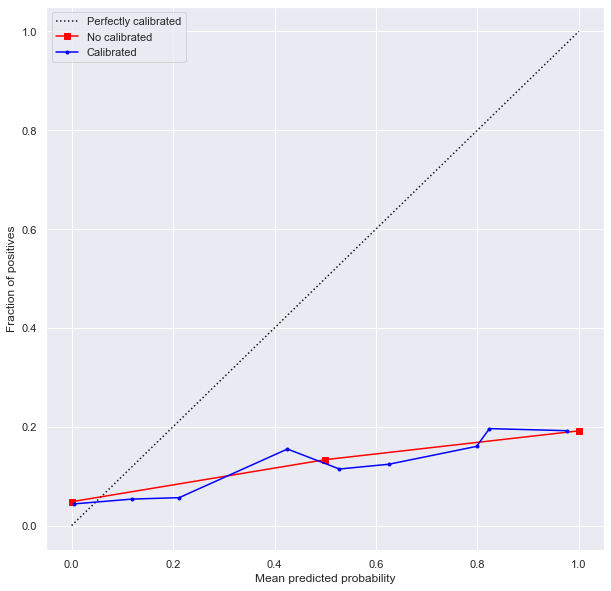

In [26]:
my_calibration_plot(model = knneig, calibrated_model = calibrated_knn, X_data = X_val, Y_data = Y_val)

### Random Forest

In [27]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=20,
                       n_estimators=550)

In [28]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [29]:
rf_metrics

{'Train': {'precision': 0.929005492579175,
  'Accuracy': 0.8890432956580816,
  'AUC': 0.9648339119117657},
 'Validation': {'precision': 0.19390926041019266,
  'Accuracy': 0.7071745015998031,
  'AUC': 0.6837548618426383}}

In [30]:
conf_mat

Pred,0,1
True,,
0,10557,3891
1,868,936


<b> Calibration

In [31]:
calibrated_rf = CalibratedClassifierCV(rfc, method='isotonic', cv=5)
calibrated_rf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=20,
                                                             min_samples_leaf=6,
                                                             min_samples_split=20,
                                                             n_estimators=550),
                       cv=5, method='isotonic')

In [32]:
rf_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_rf, X_train, Y_train, X_val, Y_val)

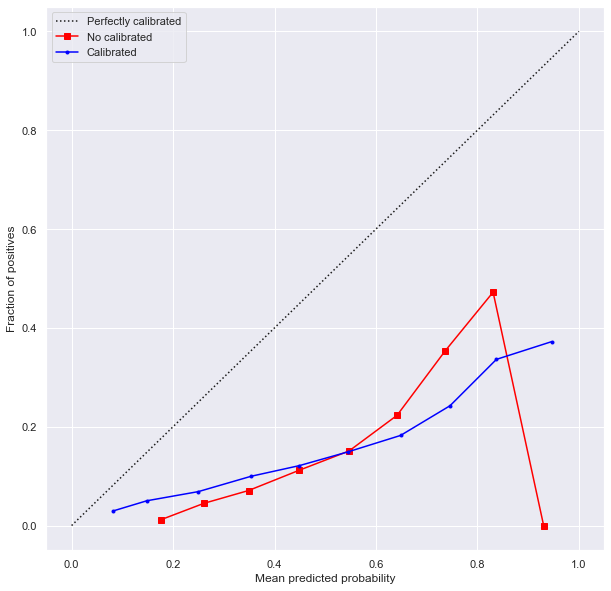

In [33]:
my_calibration_plot(model = rfc, calibrated_model = calibrated_rf, X_data = X_val, Y_data = Y_val)

<b> Summary

In [41]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.782235,0.880068,0.732848
KNN,0.275862,0.776062,0.632256
RF,0.454268,0.825290,0.720415


In [45]:
typex = 'Validation'
pd.DataFrame([svm_metrics_calib[typex],knn_metrics_calib[typex],rf_metrics_calib[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.173913,0.891842,0.556425
KNN,0.212230,0.882644,0.611888
RF,0.405063,0.890891,0.668965


## Section 3

In [34]:
train_section_3.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    62754
1     5340
Name: mahalanobis, dtype: int64

In [35]:
dict_1 = {'n':6600, 'range': [9,15], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':6800, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':6800, 'range': [9,15], 'label': 4, 'category': 2} # augmetation on the previous random ones

unscld_train_section_3 =unscaler(train_section_3, scalerx)
train_section_3_aug = augmentation_strategy(data = unscld_train_section_3, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_3
train_section_3_aug =  scaler(train_section_3_aug,scalerx)

In [36]:
train_section_3_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    62754
1     5340
2     6600
3     6800
4     6800
Name: mahalanobis, dtype: int64

### Common data to train and validation

In [37]:
seed = 158
validation_dataset_section3 = train_section_3_aug[train_section_3_aug.target.isin([0,1])].sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset_section3 = validation_dataset_section3.copy()
train_dataset_section3 = train_section_3_aug[~train_section_3_aug.index.isin(validation_dataset_section3.index)]

In [38]:
train_dataset_section3_aug = augmentation_selection_rates(train_dataset_section3, rate = 1.0, sample = 0.30)

In [39]:
len(train_dataset_section3_aug)

21381

In [40]:
X_train = train_dataset_section3_aug[numerical_features + ['mahalanobis']]
Y_train = train_dataset_section3_aug['target']

X_val = validation_dataset_section3[numerical_features + ['mahalanobis']]
Y_val = validation_dataset_section3['target']

#### Support Vector Machine

In [25]:
my_svm = svm.SVC(C = 1.0, kernel = 'rbf', gamma = 0.40, probability = True)
my_svm.fit(X_train, Y_train)

SVC(gamma=0.4, probability=True)

In [26]:
svm_metrics, conf_mat, predictions_validation = metrics_train_validation(my_svm, X_train, Y_train, X_val, Y_val)

In [27]:
svm_metrics

{'Train': {'precision': 1.0,
  'Accuracy': 0.8521220463409038,
  'AUC': 0.8239666595612305},
 'Validation': {'precision': 0.0,
  'Accuracy': 0.9159803248684512,
  'AUC': 0.5248792242296673}}

In [28]:
conf_mat

Pred,0
True,
0,16015
1,1469


<b> Calibration

In [29]:
calibrated_svm = CalibratedClassifierCV(my_svm, method='isotonic', cv=5)
calibrated_svm.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=SVC(gamma=0.4, probability=True), cv=5,
                       method='isotonic')

In [30]:
svm_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_svm, X_train, Y_train, X_val, Y_val)

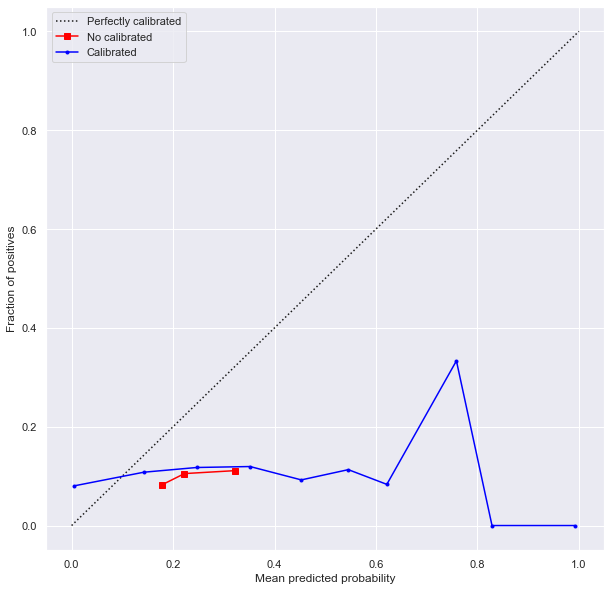

In [31]:
my_calibration_plot(model = my_svm, calibrated_model = calibrated_svm, X_data = X_val, Y_data = Y_val)

### KNN

In [41]:
knneig = KNeighborsClassifier(n_neighbors = 4)
knneig.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

In [42]:
knn_metrics, conf_mat, predictions_validation = metrics_train_validation(knneig, X_train, Y_train, X_val, Y_val)

In [43]:
knn_metrics

{'Train': {'precision': 0.9538979026513652,
  'Accuracy': 0.8774612974135915,
  'AUC': 0.9512556086109862},
 'Validation': {'precision': 0.17083333333333334,
  'Accuracy': 0.8911536654135338,
  'AUC': 0.614505534438761}}

In [44]:
conf_mat

Pred,0,1
True,,
0,15048,597
1,1256,123


<b> Calibration

In [45]:
calibrated_knn = CalibratedClassifierCV(knneig, method='isotonic', cv=5)
calibrated_knn.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=4), cv=5,
                       method='isotonic')

In [46]:
knn_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_knn, X_train, Y_train, X_val, Y_val)

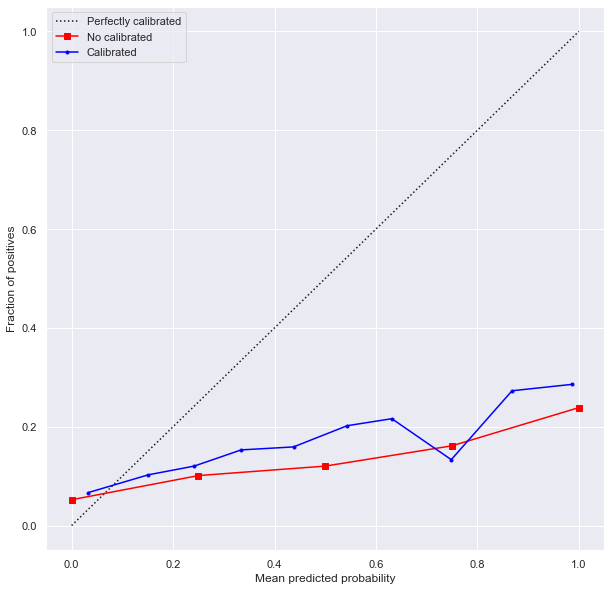

In [47]:
my_calibration_plot(model = knneig, calibrated_model = calibrated_knn, X_data = X_val, Y_data = Y_val)

### Random Forest

In [48]:
rfc = RandomForestClassifier(n_estimators = 550, max_depth = 20, min_samples_split = 20, min_samples_leaf = 6)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=6, min_samples_split=20,
                       n_estimators=550)

In [49]:
rf_metrics, conf_mat, predictions_validation = metrics_train_validation(rfc, X_train, Y_train, X_val, Y_val)

In [50]:
rf_metrics

{'Train': {'precision': 0.9997647612326511,
  'Accuracy': 0.861606098872831,
  'AUC': 0.9845831180153474},
 'Validation': {'precision': 0.6538461538461539,
  'Accuracy': 0.9194666353383458,
  'AUC': 0.665722309091933}}

In [51]:
conf_mat

Pred,0,1
True,,
0,15636,9
1,1362,17


<b> Calibration

In [52]:
calibrated_rf = CalibratedClassifierCV(rfc, method='isotonic', cv=5)
calibrated_rf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=20,
                                                             min_samples_leaf=6,
                                                             min_samples_split=20,
                                                             n_estimators=550),
                       cv=5, method='isotonic')

In [53]:
rf_metrics_calib, conf_mat_calib, predictions_validation_calib = metrics_train_validation(calibrated_rf, X_train, Y_train, X_val, Y_val)

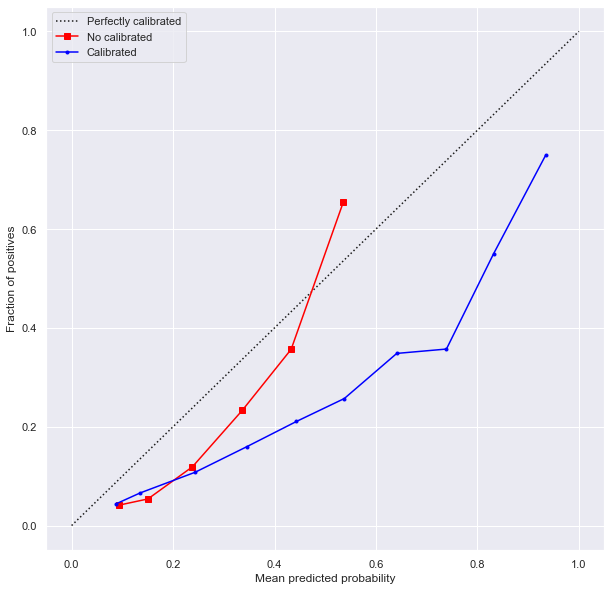

In [54]:
my_calibration_plot(model = rfc, calibrated_model = calibrated_rf, X_data = X_val, Y_data = Y_val)

<b> Summary

In [48]:
typex = 'Validation'
pd.DataFrame([svm_metrics[typex],knn_metrics[typex],rf_metrics[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.000000,0.915980,0.524879
KNN,0.143219,0.883779,0.592193
RF,1.000000,0.916152,0.646892


In [47]:
typex = 'Validation'
pd.DataFrame([svm_metrics_calib[typex],knn_metrics_calib[typex],rf_metrics_calib[typex]] ,index = ['SVM','KNN','RF'])

,precision,Accuracy,AUC
SVM,0.113514,0.907801,0.525436
KNN,0.157895,0.912263,0.584800
RF,0.307087,0.913178,0.643356


### Conclusions

* Limited or few number of variables improve computing power
* the data is splited in 3 parts thus attacking from less to most complex
* the tested models were SVM, KNN and RandomForest
* keep RF and SVM

* Section One:
    + fast execution time in general
    + it can be used the 100% of the data
* Section two:
    + fast execution time using some rate of the data
* section three:
    + low execution time , use high rate of the data or reduce dimmensionality